# Lasso implementation using ADMM(Alternating Direction Method of Multipliers)
Comparison of denoizing signals using Lasso by sklearn implementation.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 1

## Generate sparce signal and apply random-linear transform

In [2]:
# fix the seed of random
np.random.seed(0)

In [3]:
# Generate signal
idx = np.random.randint(0, 1000, 20)
signal = np.zeros(1000)
signal[idx] = np.random.normal(0.0, 1.0, 20)

In [34]:
# Generate observation matrix(random) and observation result
X = np.random.normal(0.0, 1.0, (100, 1000))
y = X.dot(signal)

X_test = np.random.normal(0.0, 1.0, (20, 1000))
y_test = X_test.dot(signal)

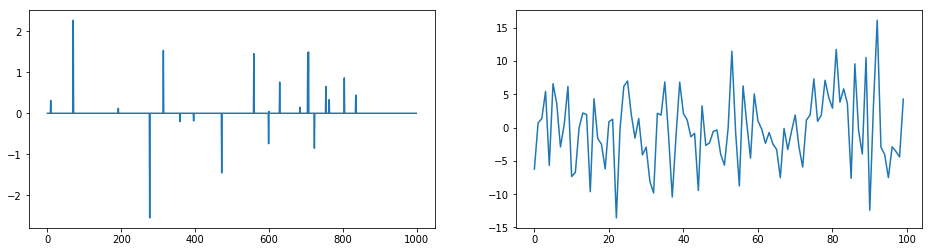

In [5]:
# Plot signal and result
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(signal)
plt.subplot(1,2,2)
plt.plot(y)
plt.show()

## Compare implementations

In [6]:
import sys
sys.path.append('..')

from sklearn.linear_model import Lasso
from spmimage.linear_model import LassoADMM

In [13]:
def get_signal(model, X):
    model = Lasso(alpha=0.1)
    model.fit(X, y)
    return model.coef_, model.predict(X)

In [14]:
model = Lasso(alpha=0.1)
model_admm = LassoADMM(alpha=0.1)

lasso_signal, lasso_predict = get_signal(model, X)
lasso_admm_signal, lasso_admm_predict = get_signal(model_admm, X)

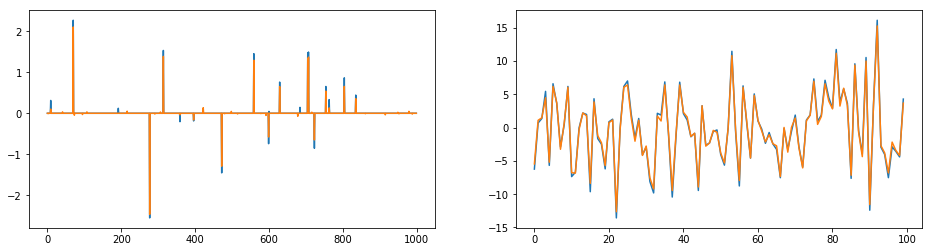

In [15]:
# Plot signal and result (sklearn)
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(signal)
plt.plot(lasso_signal)
plt.subplot(1,2,2)
plt.plot(y)
plt.plot(lasso_predict)
plt.show()

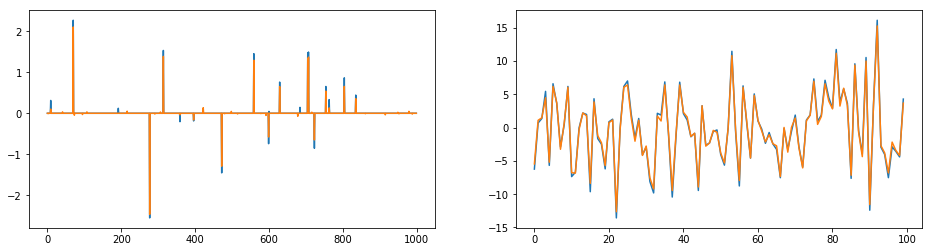

In [16]:
# Plot signal and result (ADMM)
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(signal)
plt.plot(lasso_admm_signal)
plt.subplot(1,2,2)
plt.plot(y)
plt.plot(lasso_admm_predict)
plt.show()

## Compare performances

### Time

In [31]:
%%time
model.fit(X, y)

CPU times: user 131 ms, sys: 3.68 ms, total: 135 ms
Wall time: 135 ms


Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [32]:
%%time
model_admm.fit(X, y)

CPU times: user 386 ms, sys: 23.2 ms, total: 409 ms
Wall time: 213 ms


LassoADMM(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
     normalize=False, rho=1.0, tol=0.0001)

### The numbers of iterations

In [33]:
# Compare the numbers of iterations
model.n_iter_, model_admm.n_iter_

(59, 99)

### Precision

In [35]:
model.score(X_test, y_test), model_admm.score(X_test, y_test)

(0.98001518930126152, 0.98040499519966529)